In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import time

## HYPER-PARAMETERS

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
dataroot = '../storage/my_datasets/facades/'
train_path = os.path.join(dataroot, 'train')
val_path = os.path.join(dataroot, 'val')
test_path = os.path.join(dataroot, 'test')

image_size = 256
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((268,268)),
    torchvision.transforms.RandomCrop(image_size),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.Lambda(lambda img: (np.array(img) / 127.5) - 1), #-1 TO 1 NORMALIZE
    torchvision.transforms.ToTensor(),
])

batch_size = 8
workers = 2

lr=0.0001
num_epochs = 10
num_steps = 1
k = 1

## VISUALIZE DATA

In [4]:
len(os.listdir(train_path))

400

Size: (256, 512, 3) Min/Max: 0 255


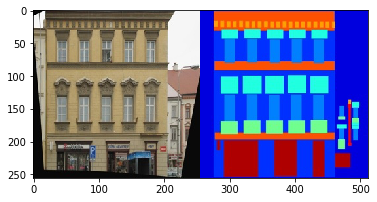

In [5]:
#VISUALIZE RAW IMAGES 

x = os.path.join(train_path,(os.listdir(train_path)[103]))
x = Image.open(x)
x_t = np.array(x)
print("Size:", x_t.shape, "Min/Max:", x_t.min(), x_t.max())
plt.imshow(x_t)

256 512 3


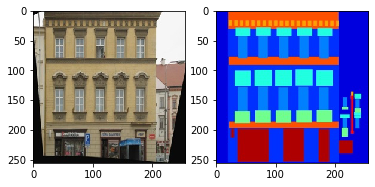

In [6]:
#VISUALIZE SPLIT IMAGES

h, w, c = x_t.shape
print(h, w, c)
w = w//2
img = x_t[:, :w, :]
lbl = x_t[:, w:, :]

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(img)
axarr[1].imshow(lbl)

## DATA LOADERS

In [7]:
class SplitDataset(torch.utils.data.Dataset):
    def __init__(self, dataroot, category, transform):
        self.dataroot = dataroot
        self.transform = transform
        self.category = category
        self.images = list(sorted(os.listdir(dataroot)))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = os.path.join(self.dataroot, self.images[index])
        image = np.array(Image.open(image).convert("RGB"))
        h, w, c = image.shape
        w = w // 2
        
        if self.category == 0:
            x = image[:, :w, :]
            if self.transform:
                x = self.transform(Image.fromarray(x))
            return x
        else:
            y = image[:, w:, :]
            if self.transform:
                y = self.transform(Image.fromarray(y))
            return y            

In [8]:
train_ds_x = SplitDataset(dataroot=train_path, category=0, transform=transform)
train_ds_y = SplitDataset(dataroot=train_path, category=1, transform=transform)
# val_ds_x = SplitDataset(root=val_path, category=0, transform=transform)
# val_ds_y = SplitDataset(root=val_path, category=1, transform=transform)
# test_ds_x = SplitDataset(root=test_path, category=0, transform=transform)
# test_ds_y = SplitDataset(root=test_path, category=1, transform=transform)

In [9]:
train_dl_x = torch.utils.data.DataLoader(train_ds_x, batch_size, shuffle=True, num_workers=workers)
train_dl_y = torch.utils.data.DataLoader(train_ds_y, batch_size, shuffle=True, num_workers=workers)

In [10]:
print("Training Set:",len(train_ds_x), len(train_ds_y))

Training Set: 400 400


## VISUALIZE LOADED DATA

In [11]:
def visualizeImages(images):
    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    plt.imshow(grid.permute(1,2,0))
    

torch.Size([8, 3, 256, 256])


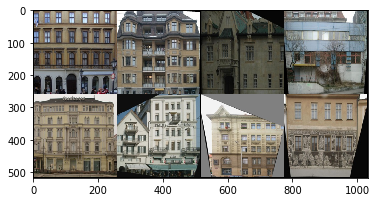

In [12]:
for xb in train_dl_x:
    print(xb.shape)
    visualizeImages(xb)
    break

torch.Size([8, 3, 256, 256])


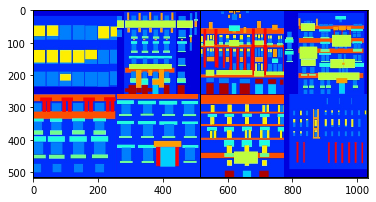

In [13]:
for yb in train_dl_y:
    print(xb.shape)
    visualizeImages(yb)
    break

## MODEL

- Output height = (Input height + padding height top + padding height bottom - kernel height) / (stride height) + 1
- Output width = (Output width + padding width right + padding width left - kernel width) / (stride width) + 1